#CIFAR-10 Classification with MLP: Advanced Techniques
This exercise demonstrates how to implement a Multi-Layer Perceptron (MLP) for classifying the CIFAR-10 dataset using PyTorch. It includes advanced concepts such as:
- Dropout for regularization.
- Early stopping to prevent overfitting.
- Proper weight initialization for numerical stability.

Note: While MLPs can work for image classification, they do not utilize the spatial structure of images and typically perform poorly on image datasets like CIFAR-10. Convolutional Neural Networks (CNNs) are better suited for these tasks. However, this tutorial focuses on MLPs to highlight their limitations and the techniques that can improve their performance.

## Step 1: Import Required Libraries
We use PyTorch for building the MLP, and torchvision for loading the CIFAR-10 dataset. Matplotlib is used for visualizing the results.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

## Step 2: Load and Preprocess the CIFAR-10 Dataset
The CIFAR-10 dataset contains 60,000 color images of 10 object classes (e.g., airplane, car, bird, etc.). Each image is 32x32 pixels with 3 color channels (RGB).

**Steps:**
1. Apply data augmentation for training (random crops and horizontal flips).
2. Normalize the pixel values to have mean 0 and standard deviation 1.
3. Split the dataset into training, validation, and test sets.
4. Use `DataLoader` to batch and shuffle the data.

In [2]:
# Define transformations: Normalize images and apply basic augmentations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB channels
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB channels
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

# Split training dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Check dataset
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

100%|██████████| 170M/170M [00:15<00:00, 11.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


## Step 3: Build the MLP Model
We define a Multi-Layer Perceptron (MLP) with:
- Two hidden layers of sizes 512 and 256.
- ReLU activation for non-linearity.
- Dropout to prevent overfitting.
- An output layer with 10 neurons (one for each class).

The input size is $32 \times 32 \times 3 = 3072$, as each CIFAR-10 image is 32x32 pixels with 3 color channels.

In [3]:
# Define the MLP model with dropout
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_prob=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout layer

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after activation
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # No activation in the output layer
        return x

# Model parameters
input_size = 32 * 32 * 3  # CIFAR-10 images are 32x32x3
hidden_size1 = 512
hidden_size2 = 256
output_size = 10  # 10 classes in CIFAR-10

# Instantiate model
model = MLP(input_size, hidden_size1, hidden_size2, output_size)
print(model)

MLP(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


## Step 4: Initialize Weights
To improve numerical stability, we initialize the weights using **He Initialization**, which is suitable for ReLU activation functions.

In [4]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')  # He Initialization
        nn.init.zeros_(m.bias)

# Apply weight initialization
model.apply(initialize_weights)

MLP(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

##Step 5: Enable GPU Acceleration
PyTorch automatically detects if CUDA is available. We'll move the model and data to the GPU if a supported GPU exists.

In [5]:
# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to GPU (if available)
model = model.to(device)

Using device: cuda


## Step 6: Define Loss Function and Optimizer
- **Loss Function**: Cross-Entropy Loss, which is suitable for multi-class classification problems.
- **Optimizer**: Adam optimizer with a learning rate of 0.001. Supplementary Material for Learning Adam Optimizer: https://www.geeksforgeeks.org/adam-optimizer/

In [6]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Step 7: Implement Early Stopping
Early stopping halts training when the validation loss stops improving, preventing overfitting.

In [7]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

## Step 8: Train the Model
The training loop computes the forward pass, loss, backpropagation, and updates weights using the optimizer. Early stopping is used to terminate training when validation loss stops improving.

In [8]:
# Training loop with early stopping
num_epochs = 50
early_stopping = EarlyStopping(patience=5, delta=0.01)
MLP_train_loss, MLP_val_loss=[], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        # Move data to GPU
        images = images.view(-1, 32 * 32 * 3).to(device)  # Flatten images
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(-1, 32 * 32 * 3).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")
    MLP_train_loss.append(train_loss/len(train_loader))
    MLP_val_loss.append(val_loss/len(val_loader))

    # Check early stopping
    early_stopping(val_loss / len(val_loader))
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Epoch [1/50], Train Loss: 2.2086, Validation Loss: 1.9506
Epoch [2/50], Train Loss: 2.0006, Validation Loss: 1.9189
Epoch [3/50], Train Loss: 1.9495, Validation Loss: 1.8657
Epoch [4/50], Train Loss: 1.9352, Validation Loss: 1.8564
Epoch [5/50], Train Loss: 1.9048, Validation Loss: 1.8251
Epoch [6/50], Train Loss: 1.8922, Validation Loss: 1.7915
Epoch [7/50], Train Loss: 1.8794, Validation Loss: 1.7992
Epoch [8/50], Train Loss: 1.8741, Validation Loss: 1.7835
Epoch [9/50], Train Loss: 1.8610, Validation Loss: 1.7613
Epoch [10/50], Train Loss: 1.8594, Validation Loss: 1.7712
Epoch [11/50], Train Loss: 1.8496, Validation Loss: 1.7644
Epoch [12/50], Train Loss: 1.8467, Validation Loss: 1.7432
Epoch [13/50], Train Loss: 1.8397, Validation Loss: 1.7395
Epoch [14/50], Train Loss: 1.8398, Validation Loss: 1.7280
Epoch [15/50], Train Loss: 1.8251, Validation Loss: 1.7219
Epoch [16/50], Train Loss: 1.8197, Validation Loss: 1.7216
Epoch [17/50], Train Loss: 1.8262, Validation Loss: 1.7142
Epoch 

## Step 9: Evaluate the Model
Evaluate the trained model on the test dataset to compute accuracy.

In [9]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 32 * 32 * 3).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 33.01%


While MLPs can work, Convolutional Neural Networks (CNNs) are much better suited for image data:

1. CNNs preserve spatial structure by using convolutional kernels to detect edges, textures, and patterns.
2. Even a simple CNN can easily outperform an MLP on CIFAR-10, often achieving 60-80% accuracy without much tuning.
If your goal is to achieve higher accuracy on CIFAR-10, moving from an MLP to a CNN (e.g., a small architecture like LeNet or VGG) is strongly recommended.

# In-class Exercise:

Q1. Batch normalization helps improve model training by normalizing the activations of each layer. Modify the MLP model to include Batch Normalization after each hidden layer. Train the updated model and compare the training/validation loss with the original model. Tutorial: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html

In [10]:
class MLP_BatchN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_prob=0.5):
        super(MLP_BatchN, self).__init__()
        self.m = nn.BatchNorm1d(input_size)  # Batch normalization layer
        self.fc1 = nn.Linear(input_size, hidden_size1)  # Fully connected layer 1
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)  # Fully connected layer 2
        self.fc3 = nn.Linear(hidden_size2, output_size)  # Fully connected layer 3
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout layer

    def forward(self, x):
        x = self.m(x)  # Apply batch normalization
        x = self.relu(self.fc1(x))  # Activation after first linear layer
        x = self.dropout(x)  # Apply dropout after activation
        x = self.relu(self.fc2(x))  # Activation after second linear layer
        x = self.dropout(x)
        x = self.fc3(x)  # Output layer (no activation)
        return x



In [11]:
# Parameters for CIFAR-10
input_size = 32 * 32 * 3  # CIFAR-10 images are 32x32x3
hidden_size1 = 512
hidden_size2 = 256
output_size = 10  # 10 classes in CIFAR-10

# Instantiate model
model = MLP_BatchN(input_size, hidden_size1, hidden_size2, output_size)
print(model)  # This will correctly print the model architecture

MLP_BatchN(
  (m): BatchNorm1d(3072, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [12]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')  # He Initialization
        nn.init.zeros_(m.bias)

# Apply weight initialization
model.apply(initialize_weights)

MLP_BatchN(
  (m): BatchNorm1d(3072, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [13]:
# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to GPU (if available)
model = model.to(device)

Using device: cuda


In [14]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [16]:
# Training loop with early stopping
num_epochs = 50
early_stopping = EarlyStopping(patience=5, delta=0.01)
b_train_loss, b_val_loss=[], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        # Move data to GPU
        images = images.view(-1, 32 * 32 * 3).to(device)  # Flatten images
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(-1, 32 * 32 * 3).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")
    b_train_loss.append(train_loss/len(train_loader))
    b_val_loss.append(val_loss/len(val_loader))

    # Check early stopping
    early_stopping(val_loss / len(val_loader))
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Epoch [1/50], Train Loss: 2.4017, Validation Loss: 1.9884
Epoch [2/50], Train Loss: 2.0541, Validation Loss: 1.9228
Epoch [3/50], Train Loss: 2.0120, Validation Loss: 1.8658
Epoch [4/50], Train Loss: 1.9829, Validation Loss: 1.8434
Epoch [5/50], Train Loss: 1.9617, Validation Loss: 1.8129
Epoch [6/50], Train Loss: 1.9456, Validation Loss: 1.7884
Epoch [7/50], Train Loss: 1.9248, Validation Loss: 1.7834
Epoch [8/50], Train Loss: 1.9091, Validation Loss: 1.7453
Epoch [9/50], Train Loss: 1.8895, Validation Loss: 1.7310
Epoch [10/50], Train Loss: 1.8830, Validation Loss: 1.7151
Epoch [11/50], Train Loss: 1.8694, Validation Loss: 1.6903
Epoch [12/50], Train Loss: 1.8566, Validation Loss: 1.6856
Epoch [13/50], Train Loss: 1.8439, Validation Loss: 1.6696
Epoch [14/50], Train Loss: 1.8377, Validation Loss: 1.6790
Epoch [15/50], Train Loss: 1.8225, Validation Loss: 1.6735
Epoch [16/50], Train Loss: 1.8136, Validation Loss: 1.6356
Epoch [17/50], Train Loss: 1.8075, Validation Loss: 1.6502
Epoch 

In [17]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 32 * 32 * 3).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 47.44%


Q2. Modify the training loop to store the training and validation loss for each epoch. Use Matplotlib to plot the curves for better visualization of the model's performance over epochs.

In [18]:
print("MLP Train Loss", MLP_train_loss, "MLP Valid Loss", MLP_val_loss)


MLP Train Loss [2.208636204338074, 2.0005887060165404, 1.9494824167251588, 1.9351898294448853, 1.9048363010406495, 1.8922373769760132, 1.879388588142395, 1.8741125165939332, 1.860966365623474, 1.8593867057800293, 1.849649312210083, 1.8466962339401245, 1.839718081855774, 1.8397781791687011, 1.8251082733154298, 1.819711312675476, 1.8261933067321778, 1.8174633365631103, 1.8108676977157592, 1.8075003034591675, 1.8165536310195922, 1.80766040725708, 1.8028711835861206, 1.8060425285339357, 1.7905732196807862, 1.7929306623458863, 1.7905792888641356] MLP Valid Loss [1.9505652151290018, 1.9188501736161057, 1.8656702702212486, 1.8563947958551394, 1.8250892891246042, 1.7915398034320515, 1.799246981645086, 1.783533755381396, 1.761312133187701, 1.7712035262660615, 1.7643616093192132, 1.743164329771783, 1.7395443817612473, 1.7280095785286775, 1.721911695352785, 1.7215548784110197, 1.714181956212232, 1.7064788432637596, 1.6979825177769752, 1.710731713635147, 1.7108490360770257, 1.6808945798570183, 1.7

In [19]:
print("BNormal ", b_train_loss, "BNormal", b_val_loss)

BNormal  [2.4017478397369385, 2.0540743286132814, 2.011981551361084, 1.9829198398590089, 1.9616971954345703, 1.945552091407776, 1.9248435913085937, 1.9091278091430663, 1.8895163101196288, 1.8830164770126343, 1.8693846303939818, 1.8566204982757568, 1.8439344116210938, 1.8376979173660277, 1.8225128564834594, 1.813600489616394, 1.8075405961990356, 1.7970915399551393, 1.7930807712554933, 1.7818186122894286, 1.7806569307327271, 1.7770027223587037, 1.7678125244140626, 1.759115579032898, 1.7548448987960816, 1.7490168478012085, 1.7495085327148439, 1.739674388885498, 1.741564423561096, 1.7357797506332397, 1.7272327587127685] BNormal [1.9883932733232048, 1.922812253046947, 1.8657813322771886, 1.8434090082812462, 1.8129014293099666, 1.7883825605841959, 1.7834043897640932, 1.7453309016622556, 1.731003367217483, 1.7151254643300535, 1.690346392856282, 1.6855564018723312, 1.6695795636268178, 1.6789685070135032, 1.673502849165801, 1.635592790166284, 1.65018044459592, 1.6271227658933896, 1.630422000672

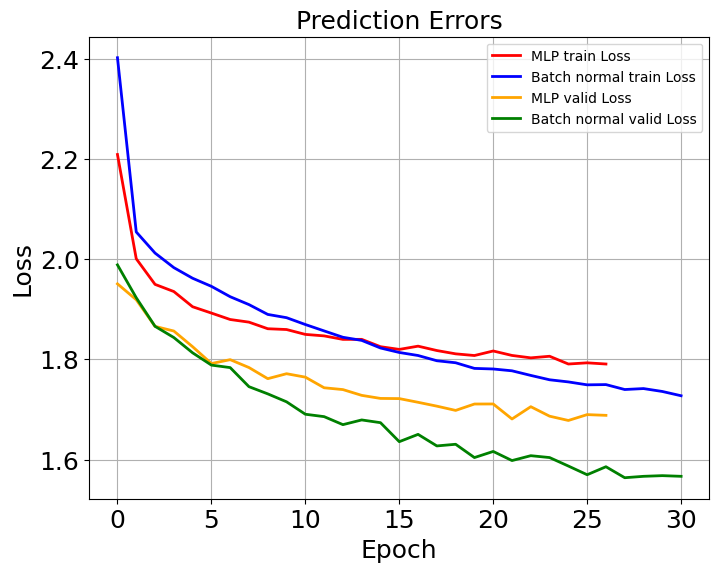

In [20]:
plt.figure(figsize=(8, 6))
indices = range(len(MLP_train_loss))
plt.plot(indices, MLP_train_loss, color='red', linestyle='-', linewidth=2, label ="MLP train Loss")
indices = range(len(b_train_loss))
plt.plot(indices, b_train_loss, color='blue', linestyle='-', linewidth=2, label ="Batch normal train Loss")
indices = range(len(MLP_val_loss))
plt.plot(indices, MLP_val_loss, color='orange', linestyle='-', linewidth=2, label ="MLP valid Loss")
indices = range(len(b_val_loss))
plt.plot(indices, b_val_loss, color='green', linestyle='-', linewidth=2, label ="Batch normal valid Loss")
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.title('Prediction Errors', fontsize=18)
plt.grid(True)
plt.tick_params(axis='both', labelsize=18)
plt.legend()
plt.show()